In [237]:
import sys
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pycountry
import geopandas
from scipy import stats

%matplotlib inline 
sns.set(color_codes=True)


### Questions we want to look at:

- Do Women and Men have similar rates of suicide?
- The Suicide rate is really increasing over the generations?
- What are some relevant factors for suicide?
- How is the suicide rates all over the world?
- What do the top 10 countries have in common? 
- GDP have an impact on suicide rates?
- How is the situation in Latin America?

## DataLoad

In [79]:
df = pd.read_csv("master.csv")
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


## Data Cleaning

In [80]:
df.rename(columns={"suicides/100k pop":"suicides_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($)":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)
print(df.columns)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_pop', 'country-year', 'HDI_for_year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')


In [81]:
#Creating Function to substitute ',' for '.' its gonna be mainly used on gdp_for_year column

def substitute_comma(dataframe,column):
    dataframe[column] = df[column].str.replace(",","").astype(np.int64)

substitute_comma(df,'gdp_for_year')



In [103]:
#Lets drop the country-year column, getting just the year, since we already have the country column

df.drop('country-year',axis='columns', inplace=True)



In [120]:
# Just putting the 05 instead of 5 so we can get it sorted and we plot a graph in the future
df["age"] = df["age"].str.replace("5-14 years","05-14 years")


In [121]:
df.head()

,country,year,sex,age,suicides_no,population,suicides_pop,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,2156624900,796,Boomers


## Exploratory Data Analysis


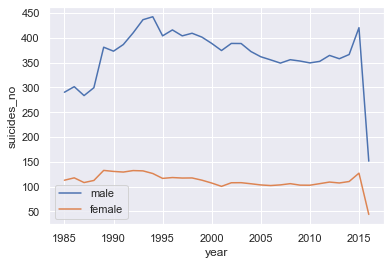

In [141]:
# Lets check what is the difference in suicide rates between men and women

men = df[df['sex'] == 'male']
women = df[df['sex'] == 'female']
sns.lineplot(men.year,men.suicides_no, ci = None);
sns.lineplot(women.year,women.suicides_no, ci = None);
plt.legend(['male','female']);
plt.show()

#### In any year, suicide numbers for men are almost 3 times higher than for women.

#### If we look at the graph, both women and men have a very similar shape during the years, having peaks at the same time. 

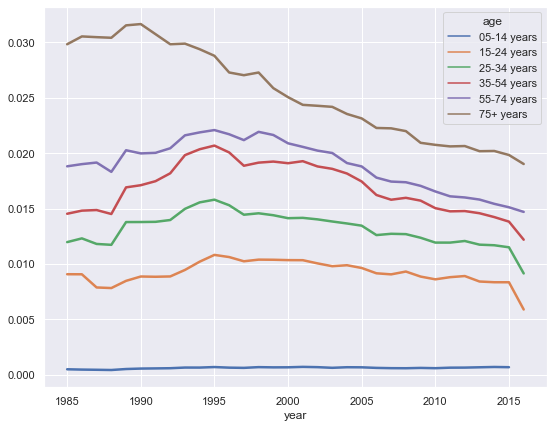

In [146]:
## Lets see if theres is any difference taking into account the age 

df_age = df.groupby(["year","age"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(9,7))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "age",
             data = df_reset, linewidth = 2.5, style = "age"
            , dashes=False)
plt.show()

#### Indeed if we look at the age, it follows a very linear behaviour, the suicide rate gets higher when the age is highter. So we can conclude that age as factor for suicide

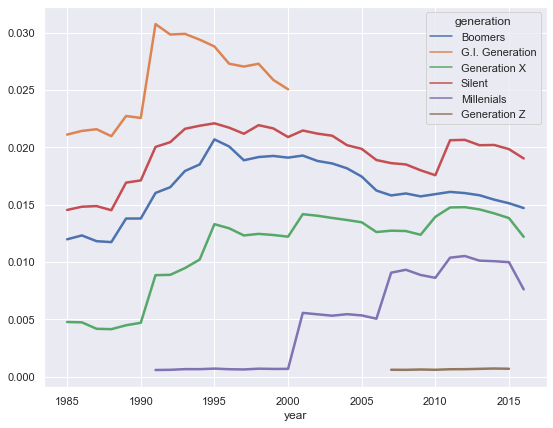

In [148]:
## Now lets check if there is any diffence on suicide rates taking in count the generation

df_age = df.groupby(["year","generation"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(9,7))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "generation",
             data = df_reset, linewidth = 2.5, style = "generation"
            , dashes=False)
plt.show()


#### We can see that in Generation X and Millenials, the suicide ratio, even in a low pace, is increasing. The higher rates of suicide are in the G.I Generation. This same generation has suffered with war and the great depression, which can explain the higher rates till 2000. After 2000 we can see a high rate in the Silent generation, which could probably be related to the effects of the WW2 but also its not as high as we can see on the G.I Generation.



In [166]:
#Lets take a look at the suicidade rate all over the world

df1 = df.groupby("country")['suicides_no'].sum()
country_name = list(df1.index.get_level_values(0))

In [169]:
#Using pycountry so we can get the the alias cor every country name

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

In [171]:
#See if there is any country missing in our list. Remembering that we used pycountry to get the country names and they may differ from the ones we have on our dataset

unlisted_country = [i for i in country_name[:] if i not in countries.keys()]
unlisted_country

['Czech Republic',
 'Macau',
 'Republic of Korea',
 'Saint Vincent and Grenadines']

In [173]:
#Couple of names differ, so we gonna change then on our dataset
df.replace("Republic of Korea", "Korea, Republic of", inplace = True)
df.replace('Czech Republic', "Czechia", inplace = True)
df.replace('Macau', 'Macao', inplace = True)
df.replace('Saint Vincent and Grenadines', "Saint Vincent and the Grenadines", inplace = True)

In [189]:
#Now we area going to sumarize the suicide rates for each country and latter on, summarize the it in two columns, 
#one for the country and one for the mean of the suicidade rates of each country
df_suino = df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suino.sort_index(ascending=True)[:] * 100

df_pop = df.groupby(["country","year"]).population.sum()
df_pop_sum = df_pop.sort_index(ascending=False)[:]

df_total = df_sum / df_pop_sum

country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]


In [204]:
#We can use Geopandas to get a couple of informations of the countries
#These informations are going to help further, to analize Latim America scenario and also the top 10

country_dict = dict()
for idx in range(len(country_list)):
    country_dict[countries[country_list[idx]]] = country_suicide[idx]

new_country_dict = {}
new_country_dict["iso_a3"] = list(country_dict.keys())
new_country_dict["suicide_rate"] = list(country_dict.values())
country_df = pd.DataFrame(new_country_dict)
country_df.head()

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
world_df = pd.merge(world, country_df, on = "iso_a3")


In [205]:
world_df

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,suicide_rate
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",0.003708
1,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",0.013131
2,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",0.012835
3,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",0.027041
4,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",0.007232
...,...,...,...,...,...,...,...
76,1221549,Asia,Cyprus,CYP,29260.0,"POLYGON ((32.73178 35.14003, 32.91957 35.08783...",0.003558
77,3856181,Europe,Bosnia and Herz.,BIH,42530.0,"POLYGON ((18.56000 42.65000, 17.67492 43.02856...",0.004351
78,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",0.019142
79,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0.008026


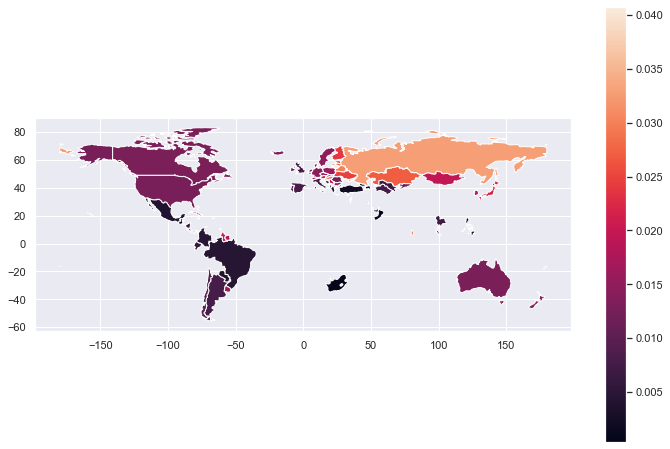

In [228]:
world_df.plot(figsize=(12,8),column='suicide_rate',legend=True);


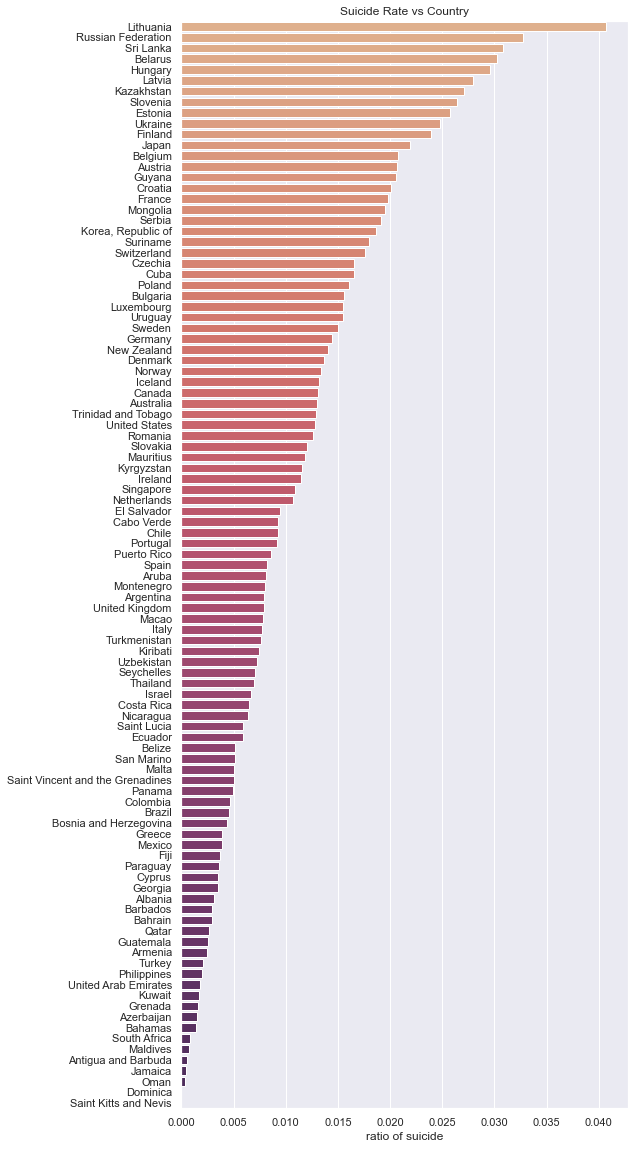

In [234]:
plt.figure(figsize=(8,20))
sns.barplot(x=country_suicide[:],y=country_list[:], palette="flare")
plt.xlabel("ratio of suicide")
plt.title("Suicide Rate vs Country")
plt.show()

#### That's very curious, if we look at the top 10 countries and also looking at the world map, a great parte of the high suicide rates comes from Eastern Europe, Indeed we can see that the higher rates are very concentrated on this area.

#### Also, we have a couple countries such as France, Japan, Korea and Austria, tava have high rates of suicide, why such countries with such a developed economy and high HDI have a high suicide rate?

#### That moves us to our next question, is the HDI and suicide rates inversely proportional? 


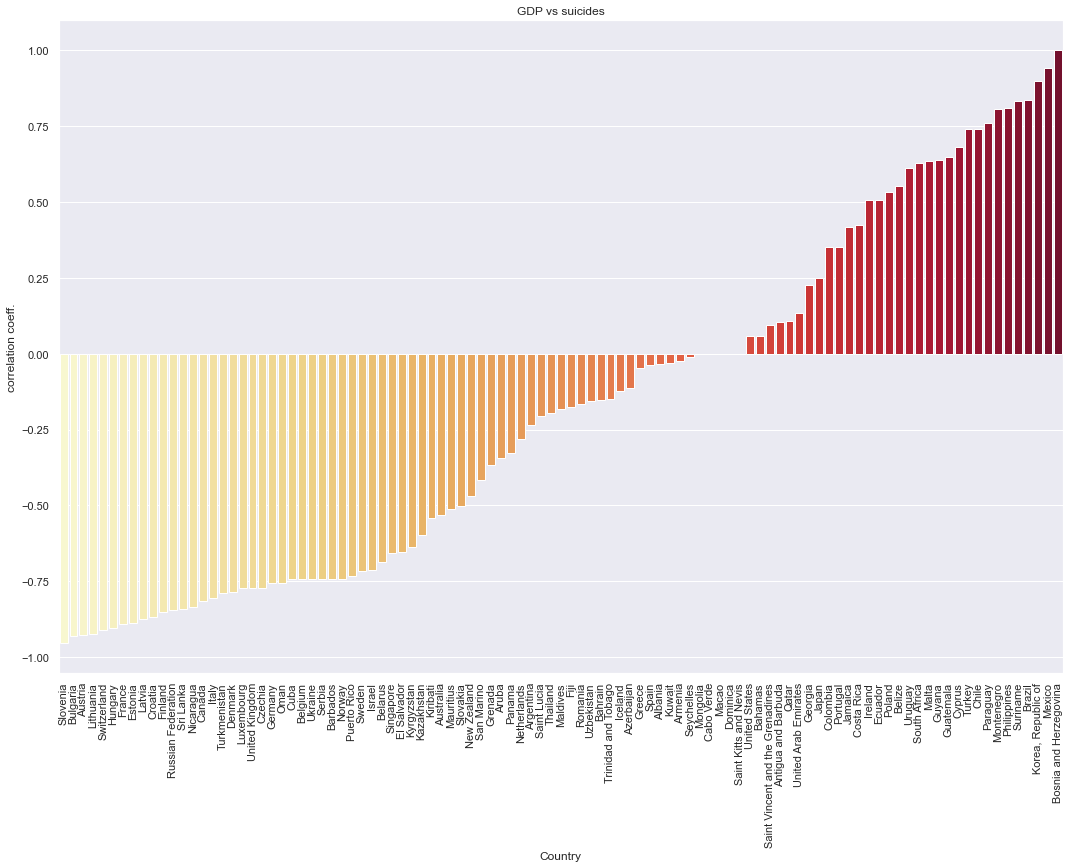

In [239]:
df_gdp = df.groupby(["country","year"]).gdp_per_capita.mean()
corr_eff = {}
p_value_eff = {}
for country in country_list[:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values, df_total[country].values)
    corr_eff[country] = float(r_value)
    p_value_eff[country] = float(p_value)

gdp_tup = list(corr_eff.items())
gdp_tup.sort(key= lambda pair:pair[1], reverse = False)
dgp_relation = {a[0]:a[1] for a in gdp_tup}

plt.figure(figsize=(18,12))
sns.barplot(x=list(dgp_relation.keys()), y=list(dgp_relation.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()